In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

### DATA

In [4]:
mDM = 500

filefolder = '../data2024/processed/cs1cs2/'

In [5]:
# # https://arxiv.org/pdf/1705.06655.pdf

# tot_B = 634.55+2.26+0.01+0.6+5.34

# f_ER = 634.55 / tot_B
# f_AC = 2.26 / tot_B
# f_CNNS = 0.01 / tot_B
# f_RN = 0.6 / tot_B
# f_WALL = 5.34 / tot_B

# f_ER + f_AC + f_CNNS + f_RN + f_WALL

In [6]:
###############
# BACKGROUNDS # 
###############

B_cs1_ER = np.loadtxt(filefolder + 'ER_cs1.txt')
B_cs2_ER = np.loadtxt(filefolder + 'ER_cs2.txt')

print('B_cs1_ER.shape: ', B_cs1_ER.shape)
print('B_cs2_ER.shape: ', B_cs2_ER.shape)


# B_cs1_AC = np.loadtxt(filefolder + 'AC_cs1.txt')
# B_cs2_AC = np.loadtxt(filefolder + 'AC_cs2.txt')

# print('\nB_cs1_AC.shape: ', B_cs1_AC.shape)
# print('B_cs2_AC.shape: ', B_cs2_AC.shape)


# B_cs1_CNNS = np.loadtxt(filefolder + 'CNNS_cs1.txt')
# B_cs2_CNNS = np.loadtxt(filefolder + 'CNNS_cs2.txt')

# print('\nB_cs1_CNNS.shape: ', B_cs1_CNNS.shape)
# print('B_cs2_CNNS.shape: ', B_cs2_CNNS.shape)


# B_cs1_RN = np.loadtxt(filefolder + 'RN_cs1.txt')
# B_cs2_RN = np.loadtxt(filefolder + 'RN_cs2.txt')

# print('\nB_cs1_RN.shape: ', B_cs1_RN.shape)
# print('B_cs2_RN.shape: ', B_cs2_RN.shape)


# B_cs1_WALL = np.loadtxt(filefolder + 'WALL_cs1.txt')
# B_cs2_WALL = np.loadtxt(filefolder + 'WALL_cs2.txt')

# print('\nB_cs1_WALL.shape: ', B_cs1_WALL.shape)
# print('B_cs2_WALL.shape: ', B_cs2_WALL.shape)


##########
# SIGNAL #
##########

S_cs1 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs1.txt')
S_cs2 = np.loadtxt(filefolder + 'WIMP_' + str(mDM) + 'GeV_cs2.txt')

print('\nS_cs1.shape: ', S_cs1.shape)
print('S_cs2.shape: ', S_cs2.shape)

B_cs1_ER.shape:  (67300,)
B_cs2_ER.shape:  (67300,)

S_cs1.shape:  (35477,)
S_cs2.shape:  (35477,)


##### Select the number of events per class

In [7]:
NUM_DAT = min(len(B_cs1_ER), len(S_cs1))
print(' NUM_DAT: ', NUM_DAT, '\n')

# NUM_DAT_AC = int(NUM_DAT*f_AC)
# NUM_DAT_CNNS = max(1, int(NUM_DAT*f_CNNS))
# NUM_DAT_RN = int(NUM_DAT*f_RN)
# NUM_DAT_WALL = int(NUM_DAT*f_WALL)

# NUM_DAT_ER = NUM_DAT - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

# print('NUM_DAT_ER: ', NUM_DAT_ER)
# print('NUM_DAT_AC: ', NUM_DAT_AC)
# print('NUM_DAT_CNNS: ', NUM_DAT_CNNS)
# print('NUM_DAT_RN: ', NUM_DAT_RN)
# print('NUM_DAT_WALL: ', NUM_DAT_WALL)



# CONCATENATE THE BACKGROUNDS
# B_cs1cs2 = np.concatenate([np.stack([B_cs1_ER,B_cs2_ER],axis=1)[:NUM_DAT_ER], np.stack([B_cs1_AC,B_cs2_AC],axis=1)[:NUM_DAT_AC], np.stack([B_cs1_CNNS,B_cs2_CNNS],axis=1)[:NUM_DAT_CNNS], np.stack([B_cs1_RN,B_cs2_RN],axis=1)[:NUM_DAT_RN], np.stack([B_cs1_WALL,B_cs2_WALL],axis=1)[:NUM_DAT_WALL]])


B_cs1cs2 = np.stack([B_cs1_ER,B_cs2_ER],axis=1)[:NUM_DAT]

print('\nB_cs1cs2.shape: ', B_cs1cs2.shape)


S_cs1cs2 = np.stack([S_cs1,S_cs2],axis=1)[:NUM_DAT]


print('\nS_cs1cs2.shape: ', S_cs1cs2.shape)

 NUM_DAT:  35477 


B_cs1cs2.shape:  (35477, 2)

S_cs1cs2.shape:  (35477, 2)


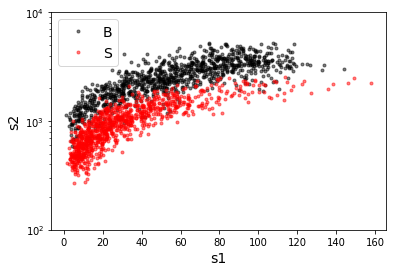

In [8]:
rnd = 100

B_cs1cs2_plot = shuffle(B_cs1cs2, random_state=rnd)
S_cs1cs2_plot = shuffle(S_cs1cs2, random_state=rnd)

plt.plot(B_cs1cs2_plot[:,0][:1000], B_cs1cs2_plot[:,1][:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], S_cs1cs2_plot[:,1][:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()

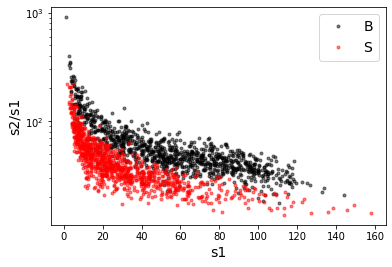

In [9]:
plt.plot(B_cs1cs2_plot[:,0][:1000], (B_cs1cs2_plot[:,1] / B_cs1cs2_plot[:,0])[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_cs1cs2_plot[:,0][:1000], (S_cs1cs2_plot[:,1] / S_cs1cs2_plot[:,0])[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2/s1',fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [9]:
# concatenate the data
X_mon_B = B_cs1cs2
X_mon_S = S_cs1cs2

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (35477, 2)
X_mon_S.shape:  (35477, 2)
X_mon.shape:  (70954, 2)

X_mon_train :  (45232, 2)
y_mon_train :  (45232,)
X_mon_val :  (7983, 2)
y_mon_val :  (7983,)
X_mon_test :  (17739, 2)
y_mon_test :  (17739,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.61899	validation_1-logloss:0.61906
[1]	validation_0-logloss:0.55772	validation_1-logloss:0.55813
[2]	validation_0-logloss:0.50657	validation_1-logloss:0.50713
[3]	validation_0-logloss:0.46316	validation_1-logloss:0.46421


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[4]	validation_0-logloss:0.42625	validation_1-logloss:0.42745
[5]	validation_0-logloss:0.39431	validation_1-logloss:0.39569
[6]	validation_0-logloss:0.36692	validation_1-logloss:0.36820
[7]	validation_0-logloss:0.34296	validation_1-logloss:0.34458
[8]	validation_0-logloss:0.32213	validation_1-logloss:0.32398
[9]	validation_0-logloss:0.30389	validation_1-logloss:0.30597
[10]	validation_0-logloss:0.28770	validation_1-logloss:0.29018
[11]	validation_0-logloss:0.27344	validation_1-logloss:0.27615
[12]	validation_0-logloss:0.26091	validation_1-logloss:0.26399
[13]	validation_0-logloss:0.24960	validation_1-logloss:0.25276
[14]	validation_0-logloss:0.23985	validation_1-logloss:0.24311
[15]	validation_0-logloss:0.23102	validation_1-logloss:0.23449
[16]	validation_0-logloss:0.22335	validation_1-logloss:0.22688
[17]	validation_0-logloss:0.21640	validation_1-logloss:0.22006
[18]	validation_0-logloss:0.21022	validation_1-logloss:0.21394
[19]	validation_0-logloss:0.20474	validation_1-logloss:0.2087

[134]	validation_0-logloss:0.15010	validation_1-logloss:0.16461
[135]	validation_0-logloss:0.15002	validation_1-logloss:0.16464
[136]	validation_0-logloss:0.14997	validation_1-logloss:0.16465
[137]	validation_0-logloss:0.14993	validation_1-logloss:0.16468
[138]	validation_0-logloss:0.14990	validation_1-logloss:0.16470
[139]	validation_0-logloss:0.14985	validation_1-logloss:0.16477
[140]	validation_0-logloss:0.14975	validation_1-logloss:0.16479
[141]	validation_0-logloss:0.14964	validation_1-logloss:0.16478
[142]	validation_0-logloss:0.14953	validation_1-logloss:0.16476
[143]	validation_0-logloss:0.14950	validation_1-logloss:0.16479
[144]	validation_0-logloss:0.14946	validation_1-logloss:0.16481
[145]	validation_0-logloss:0.14935	validation_1-logloss:0.16481
[146]	validation_0-logloss:0.14926	validation_1-logloss:0.16481


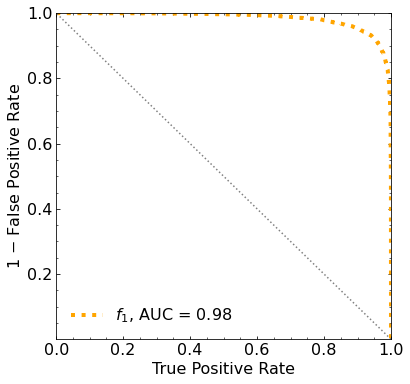

Classification score:


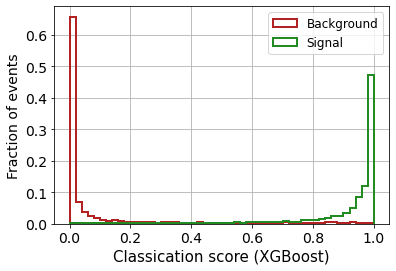


 ROC-AUC =  0.9832219704299694


In [10]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

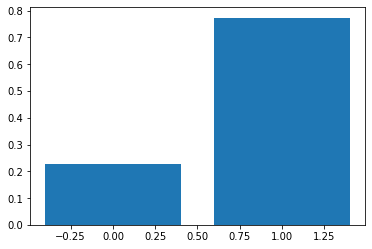

In [11]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

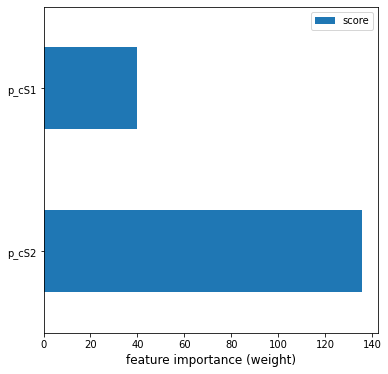

In [12]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = ['p_cS1','p_cS2']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 40 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

In [13]:
keys

['p_cS1', 'p_cS2']

In [14]:

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(classifier, X_mon_test, y_mon_test)


In [15]:


sorted_idx = classifier.feature_importances_.argsort()

sorted_idx_keys = []
for i in sorted_idx:
    sorted_idx_keys.append(keys[i])
    
sorted_idx_keys

['p_cS1', 'p_cS2']

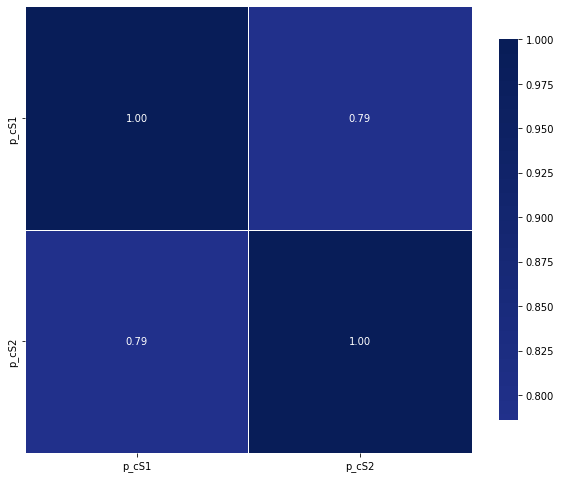

In [16]:
X = pd.DataFrame(X_mon_test, columns=keys)

def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(X[sorted_idx_keys])


### DNN

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_10 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

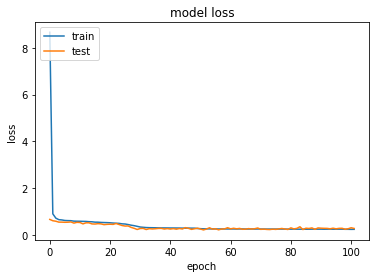

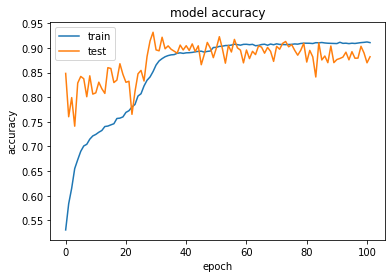

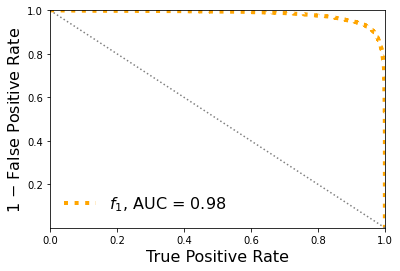

Classification score:


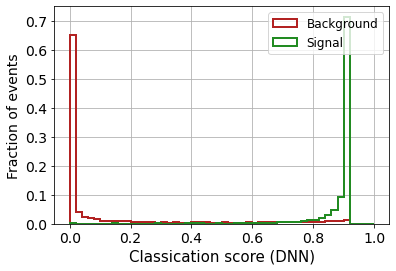


 ROC-AUC =  0.9816600334763699


In [22]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

### CNN

In [18]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
354/354 [==============================] - 1s 944us/step - loss: 13.3248 - accuracy: 0.5346 - val_loss: 0.5539 - val_accuracy: 0.5787
Epoch 2/500
354/354 [==============================] - 0s 518us/step - loss: 0.5602 - accuracy: 0.6773 - val_loss: 0.4882 - val_accuracy: 0.7889
Epoch 3/500
354/354 [==============================] - 0s 507us/step - loss: 0.5098 - accuracy: 0.7741 - val_loss: 0.4131 - val_accuracy: 0.8745
Epoch 4/500
354/354 [==============================] - 0s 529us/step - loss: 0.4418 - accuracy: 0.8281 - val_loss: 0.3924 - val_accuracy: 0.8963
Epoch 5/500
354/354 [==============================] - 0s 512us/step - loss: 0.3990 - accuracy: 0.8534 - val_loss: 0.3269 - val_accuracy: 0.9040
Epoch 6/500
354/354 [==============================] - 0s 511us/step - loss: 0.3782 - accuracy: 0.8586 - val_loss: 0.3027 - val_accuracy: 0.9270
Epoch 7/500
354/354 [==============================] - 0s 517us/step - loss: 0.3619 - accuracy: 0.8645 - val_loss: 0.2986 - val_a

354/354 [==============================] - 0s 493us/step - loss: 0.2572 - accuracy: 0.9068 - val_loss: 0.1912 - val_accuracy: 0.9367
Epoch 114/500
354/354 [==============================] - 0s 489us/step - loss: 0.2615 - accuracy: 0.9040 - val_loss: 0.1974 - val_accuracy: 0.9330
Epoch 115/500
354/354 [==============================] - 0s 492us/step - loss: 0.2549 - accuracy: 0.9060 - val_loss: 0.1980 - val_accuracy: 0.9297
Epoch 116/500
354/354 [==============================] - 0s 502us/step - loss: 0.2561 - accuracy: 0.9065 - val_loss: 0.1883 - val_accuracy: 0.9367
Epoch 117/500
354/354 [==============================] - 0s 499us/step - loss: 0.2507 - accuracy: 0.9079 - val_loss: 0.1909 - val_accuracy: 0.9372
Epoch 118/500
354/354 [==============================] - 0s 500us/step - loss: 0.2650 - accuracy: 0.9022 - val_loss: 0.1963 - val_accuracy: 0.9334
Epoch 119/500
354/354 [==============================] - 0s 491us/step - loss: 0.2577 - accuracy: 0.9043 - val_loss: 0.1882 - val_ac

Epoch 169/500
354/354 [==============================] - 0s 481us/step - loss: 0.2543 - accuracy: 0.9055 - val_loss: 0.1978 - val_accuracy: 0.9335
Restoring model weights from the end of the best epoch.
Epoch 00169: early stopping


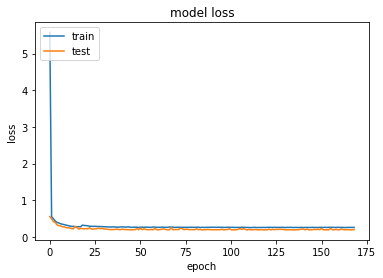

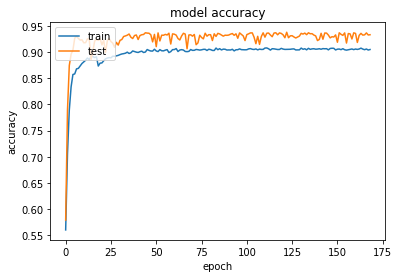

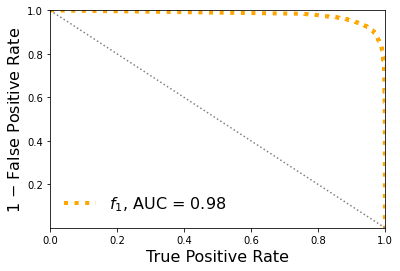

Classification score:


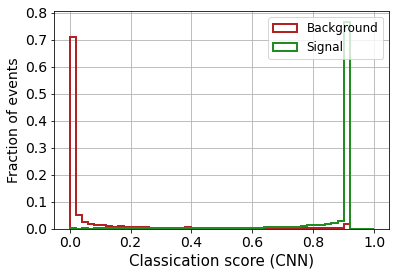


 ROC-AUC =  0.9800926178040208


In [21]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), activation='relu', strides = (1),kernel_regularizer=l2(0.005)))
#model.add(MaxPooling1D(2, strides = (1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

### 1 variable: cs2/cs1

In [10]:
# concatenate the data
X_mon_B = np.reshape( (B_cs1cs2[:,1] / B_cs1cs2[:,0]), [len(B_cs1cs2), 1])
X_mon_S = np.reshape( (S_cs1cs2[:,1] / S_cs1cs2[:,0]), [len(S_cs1cs2), 1])

# X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
# X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))
print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)

# del B_ppeakS1
# del B_ppeakS2
# del B_pbot
# del B_ptop

# del S_ppeakS1
# del S_ppeakS2
# del S_pbot
# del S_ptop

X_mon = np.concatenate([X_mon_B, X_mon_S])

# X_mon = np.concatenate([np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(S_pbot,(len(S_pbot),1))])

print('X_mon.shape: ', X_mon.shape)
# del X_mon_B
# del X_mon_S


# labels
y_mon = np.concatenate([np.zeros(NUM_DAT),np.ones(NUM_DAT)])


# divide into train-val and test data samples
test_ratio = 0.25
val_ratio = 0.15


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

X_mon_B.shape:  (35477, 1)
X_mon_S.shape:  (35477, 1)
X_mon.shape:  (70954, 1)

X_mon_train :  (45232, 1)
y_mon_train :  (45232,)
X_mon_val :  (7983, 1)
y_mon_val :  (7983,)
X_mon_test :  (17739, 1)
y_mon_test :  (17739,)



## CLASSIFIERS

### XGBoost

[0]	validation_0-logloss:0.68093	validation_1-logloss:0.68076
[1]	validation_0-logloss:0.67100	validation_1-logloss:0.67070


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-logloss:0.66279	validation_1-logloss:0.66237
[3]	validation_0-logloss:0.65602	validation_1-logloss:0.65543
[4]	validation_0-logloss:0.65036	validation_1-logloss:0.64963
[5]	validation_0-logloss:0.64565	validation_1-logloss:0.64486
[6]	validation_0-logloss:0.64170	validation_1-logloss:0.64087
[7]	validation_0-logloss:0.63835	validation_1-logloss:0.63751
[8]	validation_0-logloss:0.63555	validation_1-logloss:0.63467
[9]	validation_0-logloss:0.63313	validation_1-logloss:0.63227
[10]	validation_0-logloss:0.63108	validation_1-logloss:0.63032
[11]	validation_0-logloss:0.62935	validation_1-logloss:0.62866
[12]	validation_0-logloss:0.62788	validation_1-logloss:0.62726
[13]	validation_0-logloss:0.62662	validation_1-logloss:0.62615
[14]	validation_0-logloss:0.62555	validation_1-logloss:0.62520
[15]	validation_0-logloss:0.62460	validation_1-logloss:0.62433
[16]	validation_0-logloss:0.62373	validation_1-logloss:0.62367
[17]	validation_0-logloss:0.62303	validation_1-logloss:0.62308


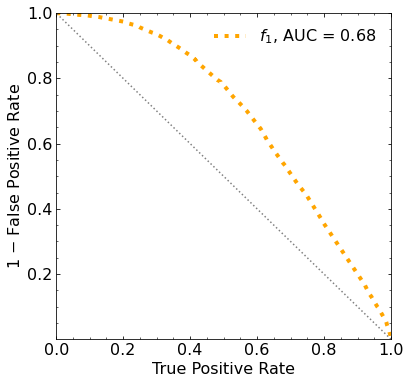

Classification score:


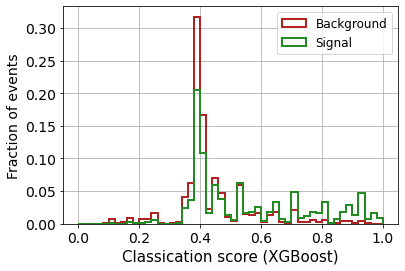


 ROC-AUC =  0.6792657812650394


In [11]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [12]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.6792657812650394


### DNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

354/354 [==============================] - 0s 554us/step - loss: 0.6754 - accuracy: 0.5875 - val_loss: 0.6698 - val_accuracy: 0.5650
Epoch 49/500
354/354 [==============================] - 0s 537us/step - loss: 0.6729 - accuracy: 0.5925 - val_loss: 0.6743 - val_accuracy: 0.5522
Epoch 50/500
354/354 [==============================] - 0s 532us/step - loss: 0.6747 - accuracy: 0.5916 - val_loss: 0.6698 - val_accuracy: 0.5622
Epoch 51/500
354/354 [==============================] - 0s 537us/step - loss: 0.6732 - accuracy: 0.5942 - val_loss: 0.6698 - val_accuracy: 0.5622
Epoch 52/500
354/354 [==============================] - 0s 528us/step - loss: 0.6754 - accuracy: 0.5876 - val_loss: 0.6730 - val_accuracy: 0.5542
Epoch 53/500
354/354 [==============================] - 0s 534us/step - loss: 0.6729 - accuracy: 0.5926 - val_loss: 0.6723 - val_accuracy: 0.5559
Epoch 54/500
354/354 [==============================] - 0s 532us/step - loss: 0.6724 - accuracy: 0.5910 - val_loss: 0.6725 - val_accuracy

354/354 [==============================] - 0s 533us/step - loss: 0.6724 - accuracy: 0.5929 - val_loss: 0.6702 - val_accuracy: 0.5572
Epoch 105/500
354/354 [==============================] - 0s 549us/step - loss: 0.6729 - accuracy: 0.5884 - val_loss: 0.6740 - val_accuracy: 0.5518
Epoch 106/500
354/354 [==============================] - 0s 539us/step - loss: 0.6709 - accuracy: 0.5925 - val_loss: 0.6682 - val_accuracy: 0.5655
Epoch 107/500
354/354 [==============================] - 0s 539us/step - loss: 0.6723 - accuracy: 0.5895 - val_loss: 0.6687 - val_accuracy: 0.5622
Epoch 108/500
354/354 [==============================] - 0s 551us/step - loss: 0.6744 - accuracy: 0.5875 - val_loss: 0.6687 - val_accuracy: 0.5629
Epoch 109/500
354/354 [==============================] - 0s 561us/step - loss: 0.6720 - accuracy: 0.5923 - val_loss: 0.6717 - val_accuracy: 0.5543
Epoch 110/500
354/354 [==============================] - 0s 549us/step - loss: 0.6713 - accuracy: 0.5940 - val_loss: 0.6738 - val_ac

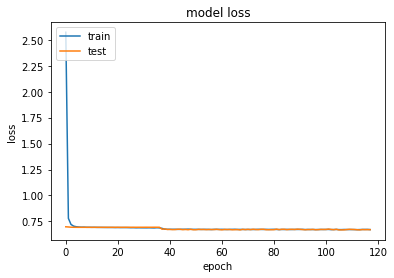

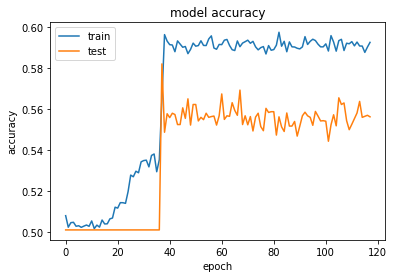

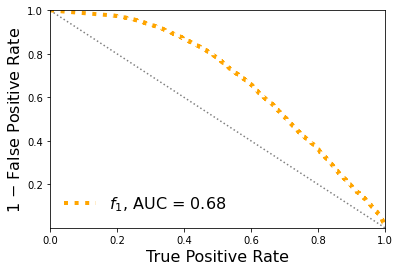

Classification score:


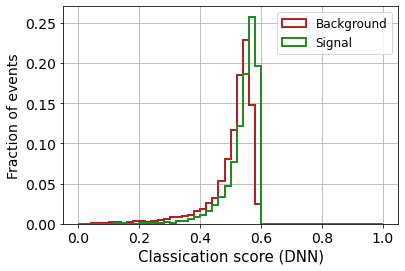


 ROC-AUC =  0.6791786810774003


In [13]:

# define the keras model
model = Sequential()
model.add(Dense(4, input_shape=(X_mon_train.shape[1],), activation='relu'))
model.add(Dropout(0.20))
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [14]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.6791786810774003
